In [1]:
import string
import re
import nltk
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
import operator

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
!pip install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download es_core_news_sm

Requirement already up-to-date: spacy in /home/javier/anaconda3/lib/python3.6/site-packages (2.2.3)
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: spacy-lookups-data in /home/javier/anaconda3/lib/python3.6/site-packages (0.2.0)
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [4]:
# https://github.com/pablodms/spacy-spanish-lemmatizer
!pip install es-lemmatizer

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import spacy
nlp = spacy.load('es_core_news_sm')

In [6]:
# rule-based lemmatization
from es_lemmatizer import lemmatize
nlp.add_pipe(lemmatize, after='tagger')

## read data

In [7]:
f = open("constitucion.txt", "r") 
constitucion=f.read()

In [8]:
constitucion[:1000]

'Capítulo I\n\n     BASES DE LA INSTITUCIONALIDAD\n\n\n\n\n     Artículo 1°.- Las personas nacen libres e iguales en dignidad y derechos.\n     La familia es el núcleo fundamental de la sociedad.\n     El Estado reconoce y ampara a los grupos intermedios a través de los cuales se organiza y estructura la sociedad y les garantiza la adecuada autonomía para cumplir sus propios fines específicos.\n     El Estado está al servicio de la persona humana y su finalidad es promover el bien común, para lo cual debe contribuir a crear las condiciones sociales que permitan a todos y a cada uno de los integrantes de la comunidad nacional su mayor realización espiritual y material posible, con pleno respeto a los derechos y garantías que esta Constitución establece.\n     Es deber del Estado resguardar la seguridad nacional, dar protección a la población y a la familia, propender al fortalecimiento de ésta, promover la integración armónica de todos los sectores de la Nación y asegurar el derecho de 

In [9]:
def clean(text,tag=None):
    text=text.split('\n') #line marker
    text=[s.strip() for s in text if len(s)>0] #blank strings and remove blank characters
    text=[s.lower() for s in text] #lower strings
    text=[nlp(s) for s in text] 
    if tag==None:
        text=[[token.lemma_ for token in s if token.pos_=='NOUN'] for s in text]#if token.tag_=='NN' or token.tag_=='NNS' or token.tag_=='JJ'] for s in text]
    elif tag=='noun_adj':
        text=[[token.lemma_ for token in s if token.pos_=='NOUN' or token.pos_=='ADJ'] for s in text]
    elif tag=='noun_verb':
        text=[[token.lemma_ for token in s if token.pos_=='NOUN' or token.pos_=='VERB'] for s in text]
    elif tag=='verb':
        text=[[token.lemma_ for token in s if token.pos_=='VERB'] for s in text]
    elif tag=='all':
        text=[[token.lemma_ for token in s if token.pos_=='NOUN' or token.pos_=='ADJ' or token.pos_=='VERB'] for s in text]
    #table = str.maketrans({key: None for key in string.punctuation}) #remove punctuation
    #text=[s.translate(table) for s in text]
    #text=[s.split(' ') for s in text] #word-tokenization
    text=[[w for w in s if w not in ['artículo','capítulo']] for s in text] #remove two meaningless words
    #pattern = re.compile('\W')
    #text=[[re.sub(pattern, '', w) for w in s] for s in text] #remove non-alphanumeric characters from strings
    #text=[[w for w in s if not w.isdigit()] for s in text] #remove digits
    text=[[w for w in s if w not in spacy.lang.es.stop_words.STOP_WORDS.union(set(stopwords.words('spanish')))] for s in text] #remove stopwords
    text=[s for s in text if len(s)>1] #remove shorter sentences

    return text

In [10]:
clean(constitucion,'noun_verb')[:10]

[['base', 'institucionalidad'],
 ['persona', 'nacer', 'dignidad', 'derecho'],
 ['familia', 'núcleo', 'sociedad'],
 ['reconocer',
  'amparar',
  'grupo',
  'organizar',
  'estructurar',
  'sociedad',
  'garantizar',
  'autonomía',
  'cumplir'],
 ['servicio',
  'persona',
  'finalidad',
  'promover',
  'contribuir',
  'crear',
  'condición',
  'permitir',
  'integrante',
  'comunidad',
  'realización',
  'material',
  'respeto',
  'derecho',
  'garantía',
  'constitución',
  'establecer'],
 ['deber',
  'resguardar',
  'seguridad',
  'protección',
  'población',
  'familia',
  'propender',
  'fortalecimiento',
  'promover',
  'integración',
  'sector',
  'nación',
  'asegurar',
  'derecho',
  'persona',
  'participar',
  'igualdad',
  'oportunidad',
  'vida'],
 ['emblema', 'bandera', 'escudo', 'arma', 'himno'],
 ['administración', 'caso', 'conformidad', 'ley'],
 ['órgano',
  'promover',
  'fortalecimiento',
  'regionalización',
  'país',
  'desarrollo',
  'región',
  'provincia',
  'comun

## networks

In [11]:
## original networks
def GoW(text_clean):
    G=nx.Graph()
    for sentence in text_clean:
        if len(sentence)>1:
            pairs=list(zip(sentence,sentence[1:]))
            for pair in pairs:
                if G.has_edge(pair[0],pair[1])==False:
                    G.add_edge(pair[0],pair[1],weight=1)
                else:
                    x=G[pair[0]][pair[1]]['weight']
                    G[pair[0]][pair[1]]['weight']=x+1
        
    return G

In [12]:
G=GoW(clean(constitucion,'noun_verb'))

In [13]:
len(G)

1392

In [14]:
nx.is_connected(G)

True

In [24]:
def plot_graph(G,tag=None):
    G = max(nx.connected_component_subgraphs(G), key=len)
    G=nx.maximum_spanning_tree(G,weight='weight')
    page_centrality = nx.betweenness_centrality(G,weight='weight')
    node_sizes=list(page_centrality.values())
    sorted_centrality = list(zip(*sorted(page_centrality.items(), key=operator.itemgetter(1),reverse=True)[:75]))[0]
    pos = nx.spring_layout(G)
    labels=labels={i:i for i in G.nodes if i in sorted_centrality}
    nx.draw_networkx_nodes(G, pos, node_size = [500*x for x in node_sizes], node_color='orange',alpha=0.75) 
    nx.draw_networkx_edges(G, pos, alpha=0.65,width=0.1,edge_color='gray')
    nx.draw_networkx_labels(G,pos,labels,alpha=0.85,font_size=2.5,font_color='k',font_family='monospace')
    plt.axis('off')
    plt.title('Constitución de Chile')
    if tag==None:
        plt.savefig('constitucion'+'_noun.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    elif tag=='noun_verb':
        plt.savefig('constitucion'+'_noun_verb.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    elif tag=='noun_adj':
        plt.savefig('constitucion'+'_noun_adj.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    elif tag=='all':
        plt.savefig('constitucion'+'_all.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    plt.show()

/home/javier/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


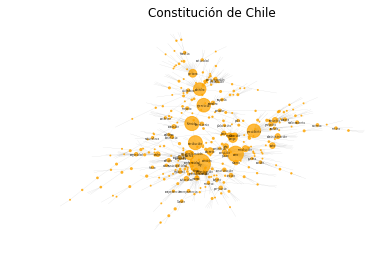

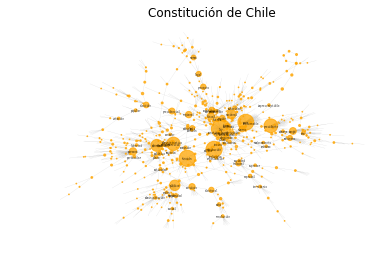

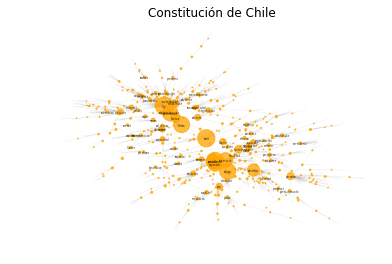

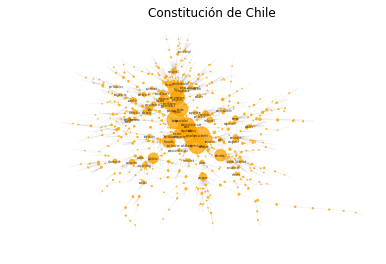

In [25]:
for tag in [None,'noun_adj','noun_verb','all']:
    G=GoW(clean(constitucion,tag))
    plot_graph(G,tag)